In [3]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import pandas as pd
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
!pip install xgboost


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [18]:
df = pd.read_csv('heart_attack_prediction_dataset.csv')

cols_to_drop = ['Patient ID', 'Country', 'Continent', 'Hemisphere']
df = df.drop(cols_to_drop, axis=1)

label_encoders = {}
for column in ['Sex', 'Diet']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Разделение давления на систолическое и диастолическое
df[['Systolic BP', 'Diastolic BP']] = df['Blood Pressure'].str.split('/', expand=True).astype(int)
df = df.drop('Blood Pressure', axis=1)

X = df.drop('Heart Attack Risk', axis=1)
y = df['Heart Attack Risk']

x_train, x_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

#Масштабирование числовых признаков
scaler = StandardScaler()
num_cols = x_train.select_dtypes(include=['int64', 'float64']).columns
x_train[num_cols] = scaler.fit_transform(x_train[num_cols])
x_val[num_cols] = scaler.transform(x_val[num_cols])
x_test[num_cols] = scaler.transform(x_test[num_cols])

# Обучение модели XGBoost
model = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

model.fit(x_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:02:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [19]:
print(f"TRAIN : {roc_auc_score(y_train, model.predict_proba(x_train)[:, 1])}")
print(f"VAL : {roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])}")
print(f"TEST : {roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])}")

TRAIN : 0.9912052775575052
VAL : 0.49955980184005655
TEST : 0.5169214437367304


In [20]:
# Предсказания на валидационном наборе
y_val_pred = model.predict(X_val)
y_val_prob = model.predict_proba(X_val)[:, 1]

# Вычисление метрик
metrics = {
    'Accuracy': accuracy_score(y_val, y_val_pred),
    'Precision': precision_score(y_val, y_val_pred),
    'Recall': recall_score(y_val, y_val_pred),
    'F1-score': f1_score(y_val, y_val_pred),
    'ROC AUC': roc_auc_score(y_val, y_val_prob)
}

# Вывод метрик
print("Метрики на валидационном наборе:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Метрики на валидационном наборе:
Accuracy: 0.6349
Precision: 0.4062
Recall: 0.0414
F1-score: 0.0751
ROC AUC: 0.4996


In [21]:
# Оценка на тестовом наборе
y_test_pred = model.predict(x_test)
y_test_prob = model.predict_proba(x_test)[:, 1]

test_metrics = {
    'Accuracy': accuracy_score(y_test, y_test_pred),
    'Precision': precision_score(y_test, y_test_pred),
    'Recall': recall_score(y_test, y_test_pred),
    'F1-score': f1_score(y_test, y_test_pred),
    'ROC AUC': roc_auc_score(y_test, y_test_prob)
}

print("\nМетрики на тестовом наборе:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")


Метрики на тестовом наборе:
Accuracy: 0.6092
Precision: 0.3874
Recall: 0.1561
F1-score: 0.2225
ROC AUC: 0.5169



Топ-10 важных признаков:
                            Feature  Importance
9           Exercise Hours Per Week    0.049056
14          Sedentary Hours Per Day    0.049032
5                    Family History    0.048843
20                      Systolic BP    0.048774
0                               Age    0.048349
21                     Diastolic BP    0.047782
2                       Cholesterol    0.047636
16                              BMI    0.047270
17                    Triglycerides    0.046634
3                        Heart Rate    0.046128
15                           Income    0.045954
7                           Obesity    0.045321
8               Alcohol Consumption    0.045224
12                   Medication Use    0.044382
4                          Diabetes    0.044154
19              Sleep Hours Per Day    0.043835
13                     Stress Level    0.043332
11          Previous Heart Problems    0.043138
1                               Sex    0.042147
10            

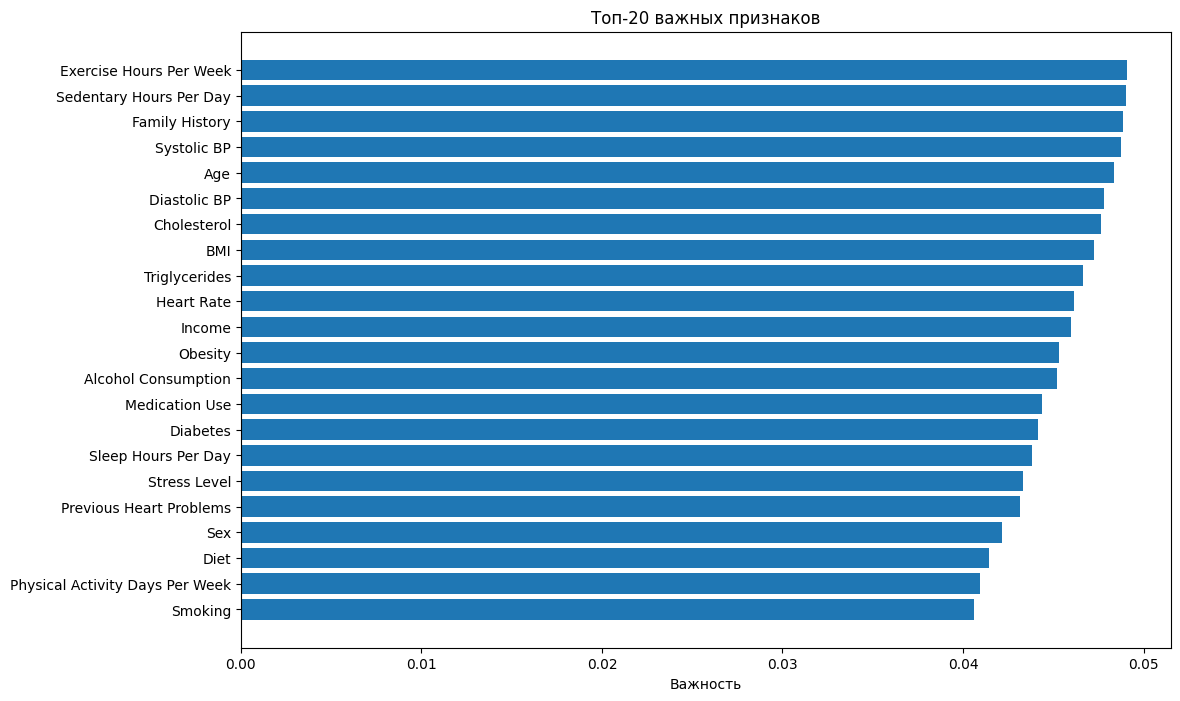

In [22]:
# Важность признаков
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nТоп-10 важных признаков:")
print(feature_importance.head(25))

# Визуализация важности признаков
plt.figure(figsize=(12, 8))
plt.barh(feature_importance['Feature'][:25], feature_importance['Importance'][:25])
plt.xlabel('Важность')
plt.title('Топ-20 важных признаков')
plt.gca().invert_yaxis()
plt.show()